In [ ]:
!pip install transformers evaluate
!pip install accelerate -U

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers

In [ ]:
fakeNews = pd.read_csv("Fake.csv")
trueNews = pd.read_csv("True.csv")

In [ ]:
fakeNews["title"] = fakeNews["title"].replace("â€™","",regex=True)

In [ ]:
fakeNews["title"] = fakeNews["title"].replace("â€˜","",regex=True)

In [ ]:
fakeNews["title"] = fakeNews["title"].replace("â€“","",regex=True)

In [ ]:
fakeNews["label"] = 1  #adding an aditional row to classify, will be useful later
trueNews["label"] = 0  #1 for fake news and 0 for true news

In [ ]:
totalNews = pd.concat([fakeNews, trueNews], axis=0) #concatinating the datasets together

In [ ]:
totalNews.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [ ]:
#randomly shuffels the data
totalNews = totalNews.sample(frac = 1)

In [ ]:
#arranges the data in order
totalNews.reset_index(inplace = True)
totalNews.drop(["index"], axis = 1, inplace = True)

In [ ]:
totalNews.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


In [ ]:
x = totalNews["title"]
y = totalNews["label"]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state = 42)  #training split is 70% training, 30% for val and testing

x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state = 42) #splitting so its 50:50 for val and testing

In [ ]:
from transformers import AutoModelForSequenceClassification, BertTokenizerFast

#Loading the AutoModelForSequenceClassification BERT
bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# sample data
text = ["this is a bert base tokener", "fine tuning a bert model takes to long"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

print([tokenizer.decode(sent_id["input_ids"][i]) for i in range(2)])

['[CLS] this is a bert base tokener [SEP] [PAD]', '[CLS] fine tuning a bert model takes to long [SEP]']


In [ ]:
print("The input ids:", sent_id["input_ids"])
print("\n The attention Masks:", sent_id["attention_mask"])

The input ids: [[101, 2023, 2003, 1037, 14324, 2918, 19204, 2121, 102, 0], [101, 2986, 17372, 1037, 14324, 2944, 3138, 2000, 2146, 102]]

 The attention Masks: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


<Axes: >

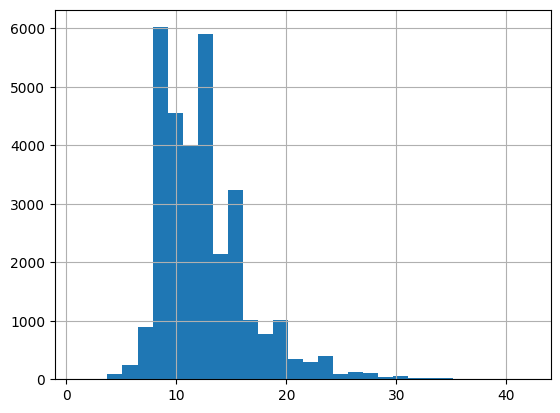

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in x_train]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
#as per the above graph max sequence length is around 30
max_seq_len = 30

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    x_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    x_val.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    x_test.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batchSize = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batchSize)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batchSize)

#testing data
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batchSize)

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert for Fake News",
    evaluation_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batchSize,
    per_device_eval_batch_size=batchSize,
    num_train_epochs=2,
    weight_decay=0.01,
)

In [ ]:
'''def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}'''

'def compute_metrics(eval_predictions):\n    predictions, label_ids = eval_predictions\n    preds = np.argmax(predictions, axis=1)\n    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}'

In [ ]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

def compute_metrics(eval_pred):

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)

   rouge = metric.compute(predictions=predictions, references=labels, average="micro")["f1"]
   return {"f1": rouge}

In [ ]:
#this dummy data collector helps the transformer to run
def dummy_data_collector(features):
    batch = {}
    batch['input_ids'] = torch.stack([f[0] for f in features])
    batch['attention_mask'] = torch.stack([f[1] for f in features])
    batch['labels'] = torch.stack([f[2] for f in features])

    return batch

In [ ]:
trainer = Trainer(
    bert,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=dummy_data_collector,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.116700,0.018027,0.994031
2,0.022200,0.003560,0.998797


TrainOutput(global_step=1966, training_loss=0.05379969348500001, metrics={'train_runtime': 507.7556, 'train_samples_per_second': 123.792, 'train_steps_per_second': 3.872, 'total_flos': 969029794670400.0, 'train_loss': 0.05379969348500001, 'epoch': 2.0})

In [ ]:
prediction = trainer.predict(test_data)

In [ ]:
print(prediction.metrics)

{'test_loss': 0.028580162674188614, 'test_f1': 0.9935854603768542, 'test_runtime': 39.4918, 'test_samples_per_second': 568.448, 'test_steps_per_second': 17.776}
